In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

In [2]:
# Crear un DataFrame a partir de un diccionario
data = {
    'Parametro': ['Temperatura','Turbidez','Color','Conductividad','SDT','Ph','OD',"DQO",'Nitratos','Nitritos','Fosfatos','Metales'],#SDT es solidis disueltos totales,OD=Oxigeno disuelto,DQO=Demanda química de oxígeno
    'Limite_Inferior': [5,1,15,100,500,6.5,6,30,10,0.1,0.5,0.005],
    'Limite_Superior': [20,5,30,500,100,8.5,8,50,50,0.3,1.0,0.001],
    'Unidades':['°C','NTU','UC','µS/cm','mg/L','-','mg/L','mg/L','mg/L','mg/L','mg/L','mg/L'],
}

df = pd.DataFrame(data)

# Imprimir el DataFrame
df

,Parametro,Limite_Inferior,Limite_Superior,Unidades
0,Temperatura,5.000,20.000,°C
1,Turbidez,1.000,5.000,NTU
2,Color,15.000,30.000,UC
3,Conductividad,100.000,500.000,µS/cm
4,SDT,500.000,100.000,mg/L
5,Ph,6.500,8.500,-
6,OD,6.000,8.000,mg/L
7,DQO,30.000,50.000,mg/L
8,Nitratos,10.000,50.000,mg/L
9,Nitritos,0.100,0.300,mg/L


In [3]:
def plot_series(series, y=None, y_pred=None, y_pred_std=None, x_label="$t$", y_label="$x$"):
  r, c = 3, 5
  fig, axes = plt.subplots(nrows=r, ncols=c, sharey=True, sharex=True, figsize=(20, 10))
  for row in range(r):
    for col in range(c):
        plt.sca(axes[row][col])
        ix = col + row*c
        plt.plot(series[ix, :], ".-")
        if y is not None:
            plt.plot(range(len(series[ix, :]), len(series[ix, :])+len(y[ix])), y[ix], "bx", markersize=10)
        if y_pred is not None:
            plt.plot(range(len(series[ix, :]), len(series[ix, :])+len(y_pred[ix])), y_pred[ix], "ro")
        if y_pred_std is not None:
            plt.plot(range(len(series[ix, :]), len(series[ix, :])+len(y_pred[ix])), y_pred[ix] + y_pred_std[ix])
            plt.plot(range(len(series[ix, :]), len(series[ix, :])+len(y_pred[ix])), y_pred[ix] - y_pred_std[ix])
        plt.grid(True)
        plt.hlines(0, 0, 100, linewidth=1)
        plt.axis([0, len(series[ix, :])+len(y[ix]), -1, 1])
        if x_label and row == r - 1:
          plt.xlabel(x_label, fontsize=16)
        if y_label and col == 0:
          plt.ylabel(y_label, fontsize=16, rotation=0)
  plt.show()



In [4]:
#funcion para crear dataset sintetico
def DataSintetica(inicio, fin, paso,data, variabilidad=0.01):
  diccionario={}
  for indice, fila in data.iterrows():
    # Generar un arreglo de valores de x
    x_vals = np.arange(inicio, fin, paso)+np.random.randint(1, 8)

    # Calcular los valores de seno con variabilidad
    seno =(((np.sin(x_vals/np.random.uniform(1, 3))+1)/2)*(fila['Limite_Superior']-fila['Limite_Inferior'])+fila['Limite_Inferior'])*1.1
    vari=0.1*(fila['Limite_Superior']-fila['Limite_Inferior'])
    ruido = np.random.uniform(low=-vari, high=vari, size=x_vals.size)
    seno+=ruido
    #seno = (np.sin(x_vals/np.random.uniform(1, 3.5))/2 + np.random.uniform(-variabilidad, variabilidad, size=len(x_vals))+1+fila['Limite_Inferior'])*fila['Limite_Superior']-fila['Limite_Inferior']
    diccionario[fila['Parametro']]=seno
  return diccionario

In [34]:
# Generar valores de seno con variabilidad
dataSintetica = DataSintetica(0, 502.5, 0.05,df, variabilidad=0.05)

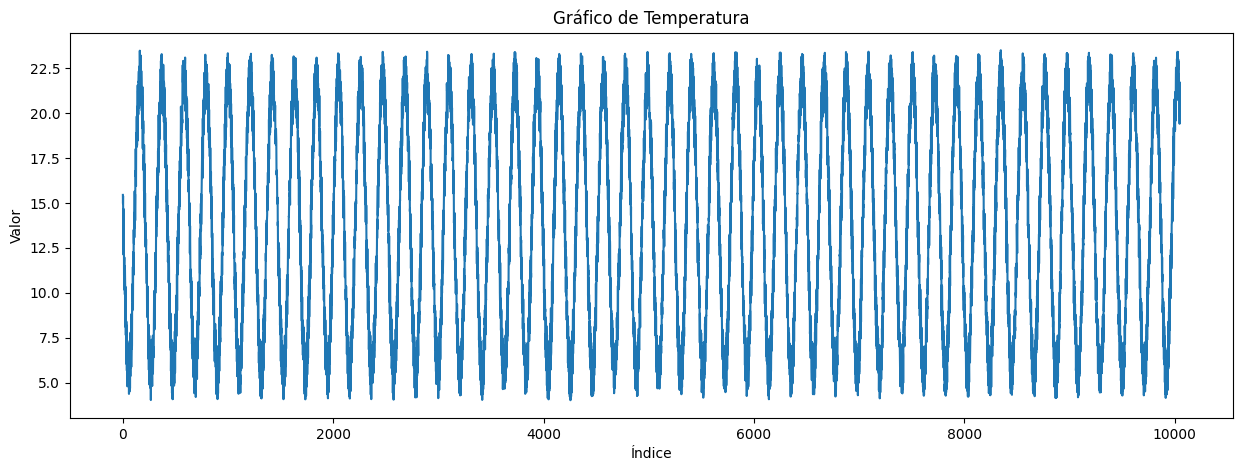

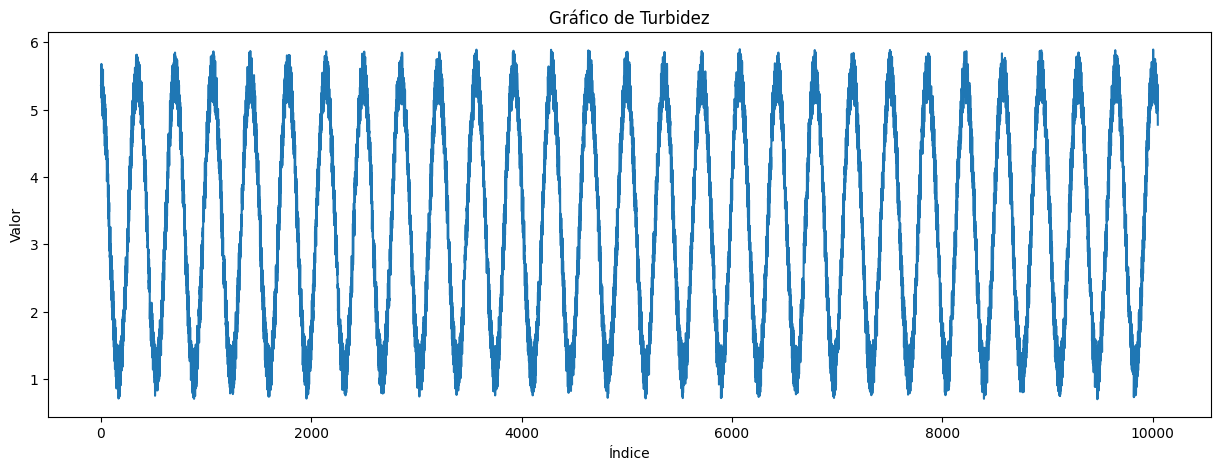

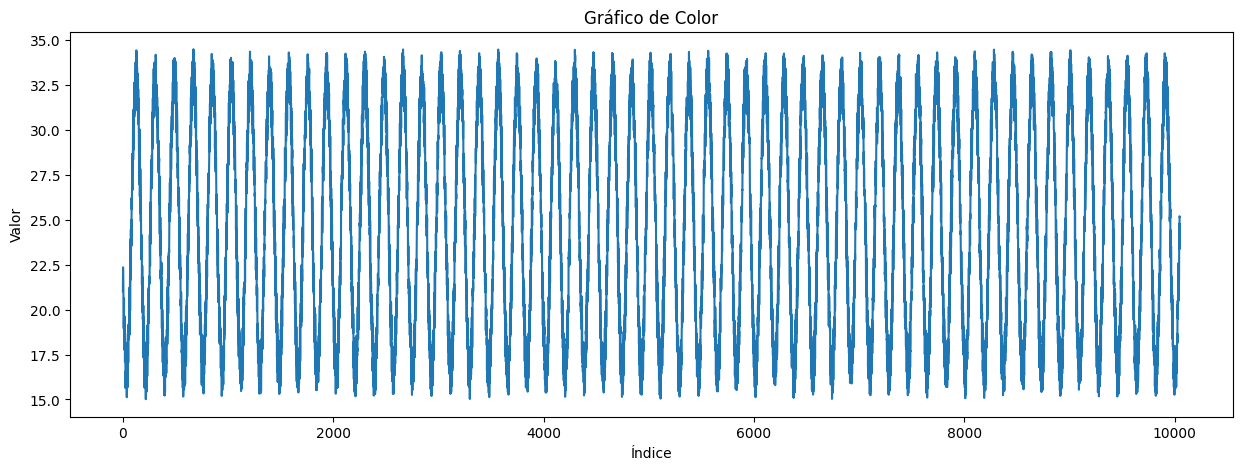

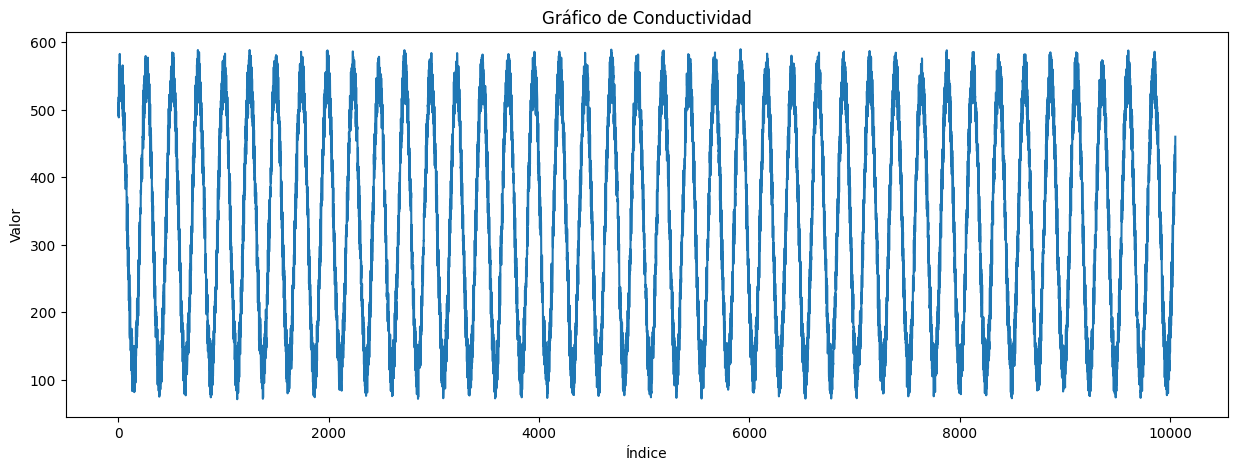

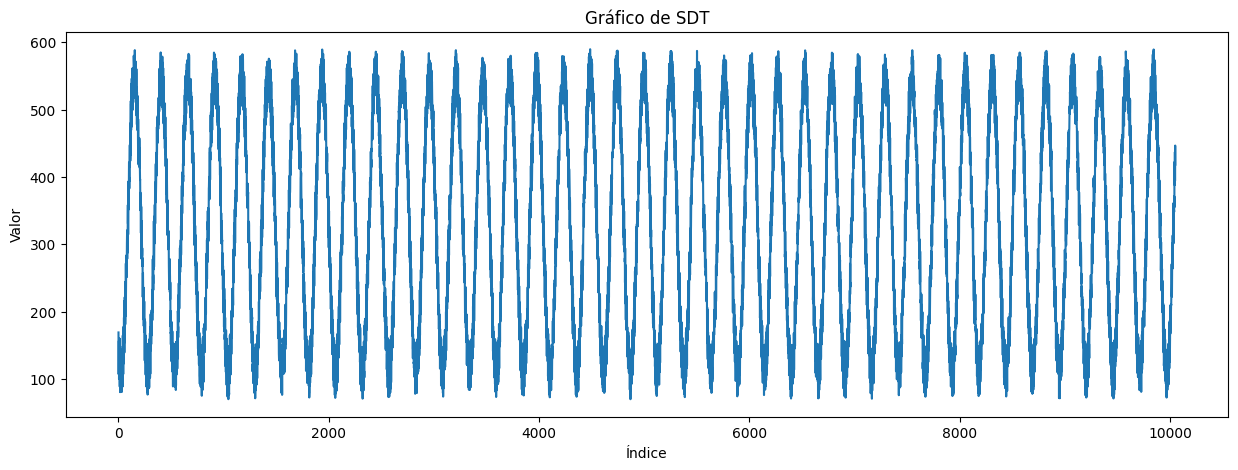

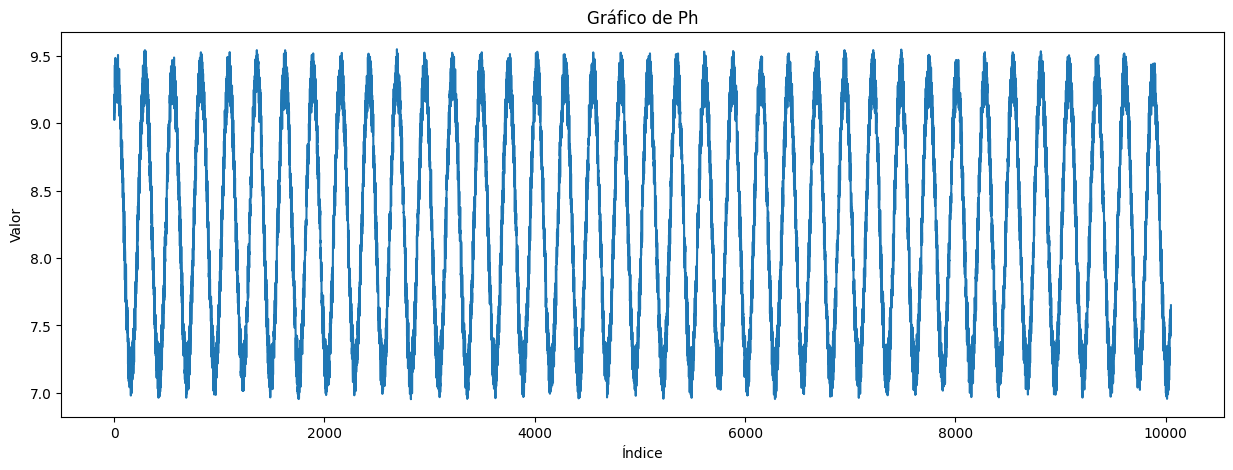

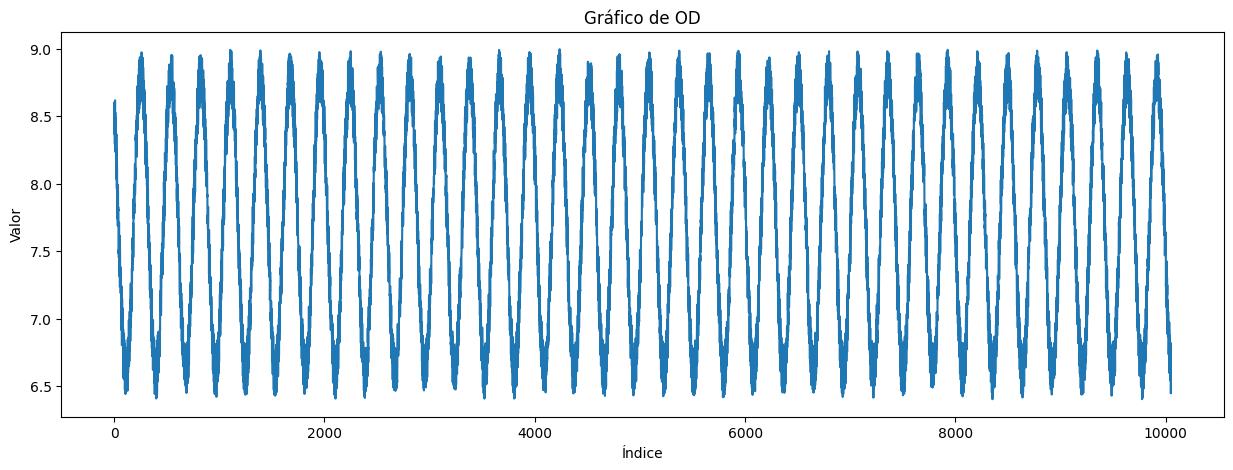

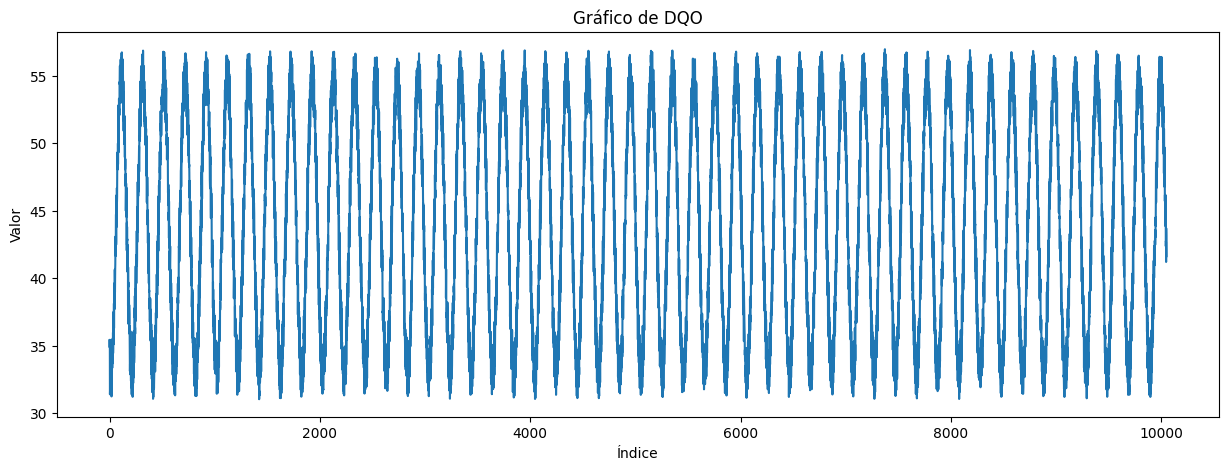

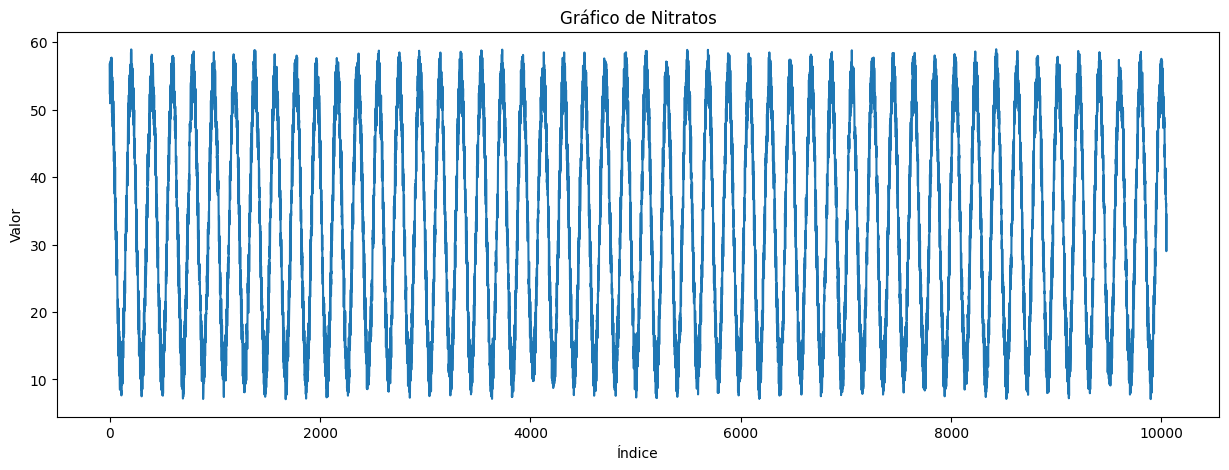

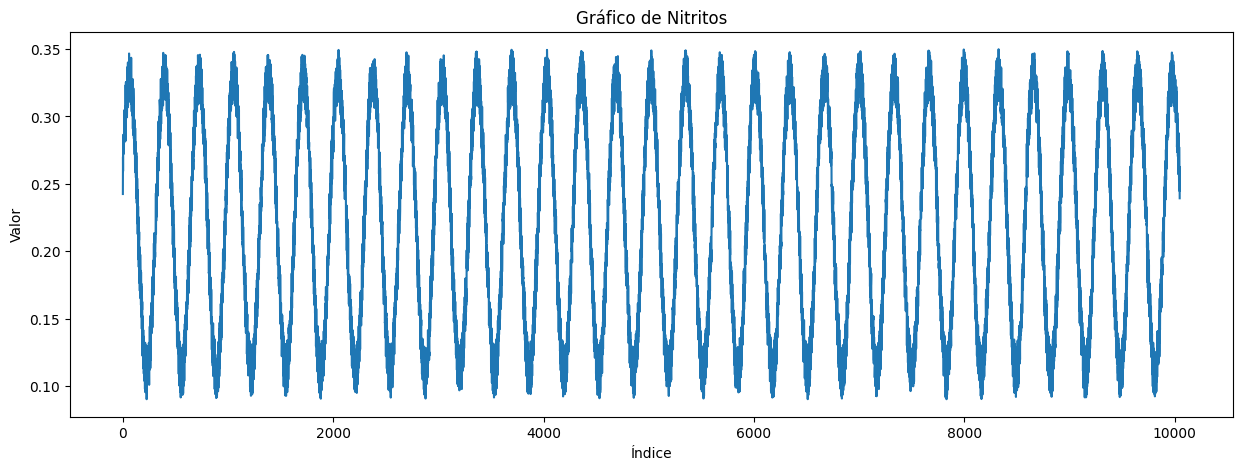

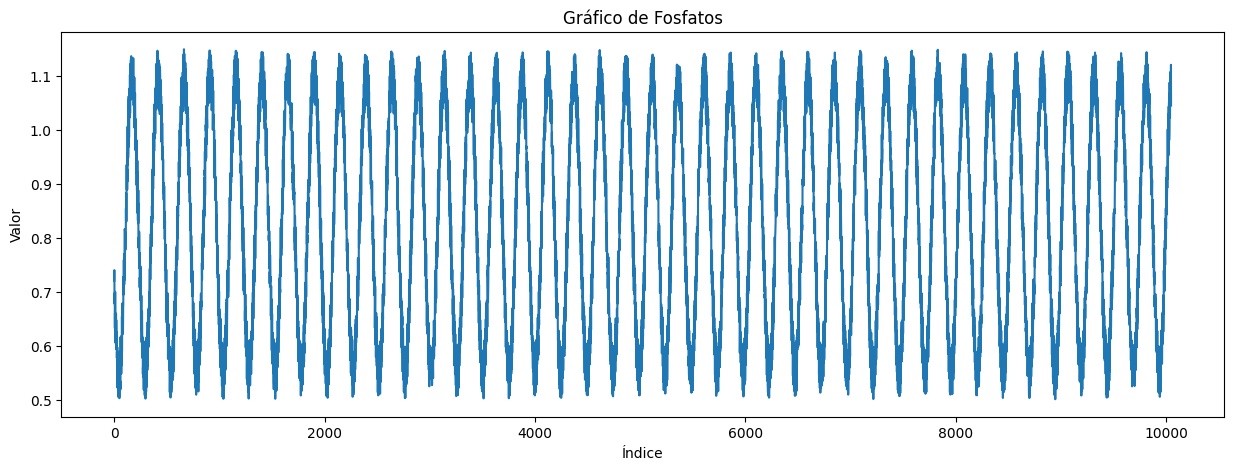

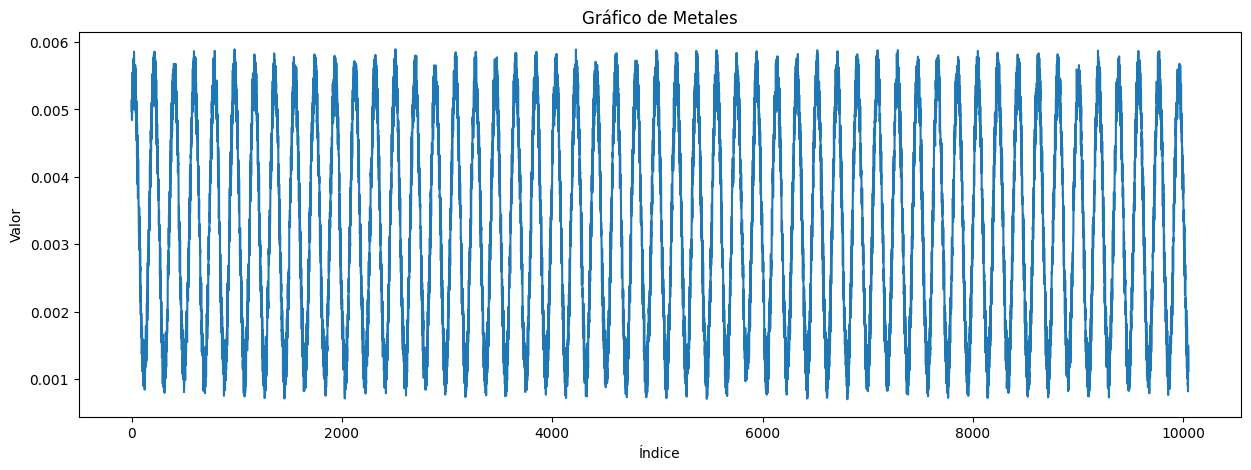

In [35]:
# Graficar cada serie en el diccionario por separado
for nombre_serie, valores in dataSintetica.items():
    plt.figure(figsize=(15, 5))  # Ajustar el tamaño de la figura
    plt.plot(valores)
    plt.xlabel('Índice')
    plt.ylabel('Valor')
    plt.title(f'Gráfico de {nombre_serie}')
    plt.show()  # Mostrar la gráfica

In [36]:
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # Encuentra el final del patrón
        end_ix = i + n_steps
        # Sal de bucle si ya no hay suficientes datos para predecir
        if end_ix > len(sequence)-1:
            break
        # Divide la secuencia en entrada y salida
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x[..., np.newaxis].astype(np.float32))  # Añadir una dimensión extra
        y.append(seq_y[..., np.newaxis].astype(np.float32))  # Añadir una dimensión extra a y
    return np.array(X), np.array(y)

In [37]:
def split_sequence_dict(input_dict, n_steps):
    output_dict = {}
    for key, value in input_dict.items():
        X, y = split_sequence(value, n_steps)
        output_dict[key] = {'X': X, 'y': y}
    return output_dict

In [38]:
dataSintetica = split_sequence_dict(dataSintetica, 50)

In [39]:
dataSintetica['Color']['y'].shape

(10000, 1)

In [40]:
def split_dict_data(data_dict, train_ratio=0.9):
    train_data = {}
    test_data = {}

    for key, value in data_dict.items():
        X_train, X_test, y_train, y_test = train_test_split(value['X'], value['y'], test_size=1-train_ratio, random_state=42)
        # Almacena los datos en los diccionarios correspondientes
        train_data[key] = {'X': X_train, 'y': y_train}
        test_data[key] = {'X': X_test, 'y': y_test}

    return train_data, test_data

In [41]:
def split_Traint_Test_dict(input_dict, porcentaje):
    output_dict = {}
    train_data ={}
    test_data ={}
    for key, value in input_dict.items():
        #print(type(value))
        X_train, Xval_test, y_train, Yval_test = train_test_split(value['X'], value['y'], test_size=1-porcentaje, random_state=42)
        X_test, X_eval = np.split(Xval_test, 2)
        y_test, Y_eval = np.split(Yval_test, 2)
        # Almacena los datos en los diccionarios correspondientes
        train_data = {'X': X_train, 'y': y_train}
        test_data = {'X': X_test, 'y': y_test}
        eval_data = {'X': X_eval, 'y': Y_eval}
        #X, y = split_dict_data(value,porcentaje)
        output_dict[key] = {'train': train_data, 'test': test_data, 'eval': eval_data}
    return output_dict

In [42]:
# Llamar a la función para dividir el diccionario
data_final = split_Traint_Test_dict(dataSintetica, 0.9)

In [43]:
import matplotlib.pyplot as plt

def plot_arrays(a, b=None, c=None):
    # Normalizar los arrays dividiendo cada uno por su valor máximo
    a_normalized = a / a.max() if a is not None else None
    b_normalized=None
    c_normalized=None


    if b is not None:
      b_normalized = b / a.max()

    if c is not None:
      c_normalized = c / a.max()

    # Graficar cada una de las primeras 10 imágenes de a en gráficos separados
    num_plots = min(10, len(a_normalized))

    for i in range(num_plots):
        fig, ax = plt.subplots()
        ax.plot(np.arange(a.shape[1]),a_normalized[i, :, 0],'o', label='serie', color='blue')
        #print(b_normalized[i][0])
        if b_normalized is not None:
          ax.plot(np.arange(a.shape[1],a.shape[1]+1),b_normalized[i][0],'o', label='real', color='red')
        if c_normalized is not None:
          ax.plot(np.arange(a.shape[1],a.shape[1]+1),c_normalized[i][0],'o', label='predicho', color='green')
        ax.set_xlabel('Eje X')
        ax.set_ylabel('Eje Y')
        ax.set_title('Gráfico de puntos con 3 arrays NumPy')
        ax.legend()
        plt.show()

In [47]:
X_test=data_final['Color']['test']['X']
y_test=data_final['Color']['test']['y']
X_train=data_final['Color']['train']['X']
y_train=data_final['Color']['train']['y']
X_valid=data_final['Color']['eval']['X']
y_valid=data_final['Color']['eval']['y']
print(type(X_test)), print(type(y_test))
X_test.shape, y_test.shape

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


((500, 50, 1), (500, 1))

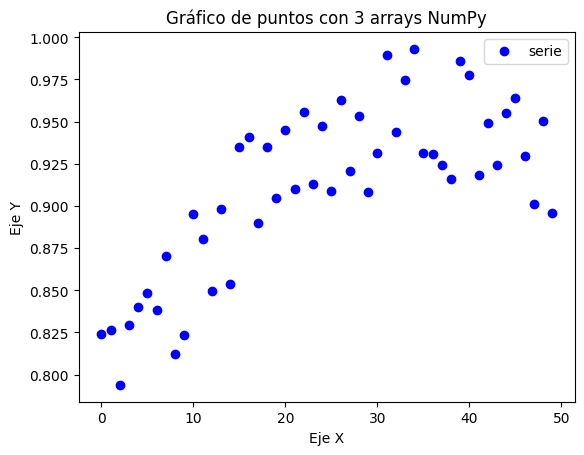

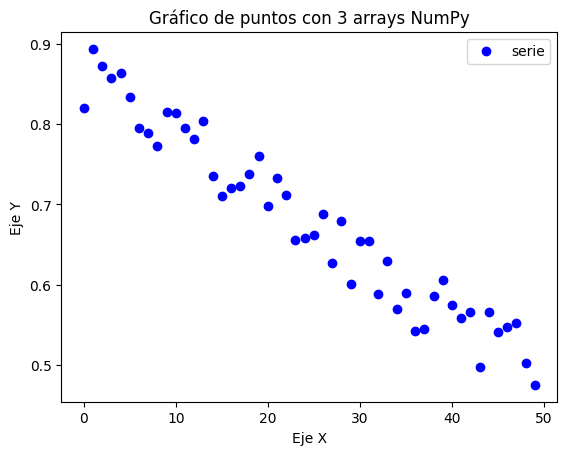

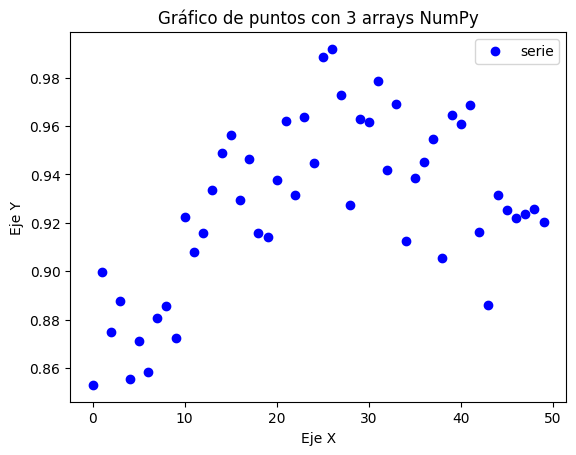

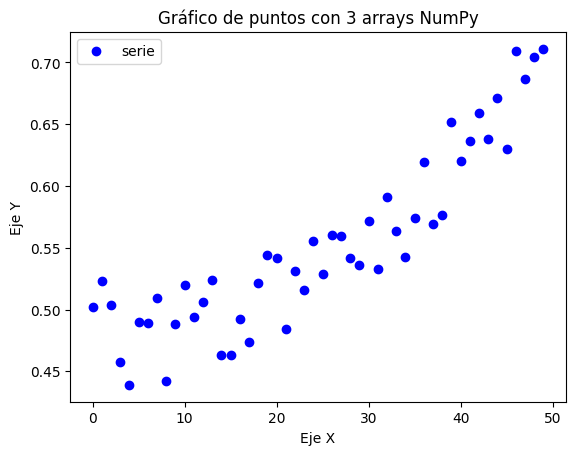

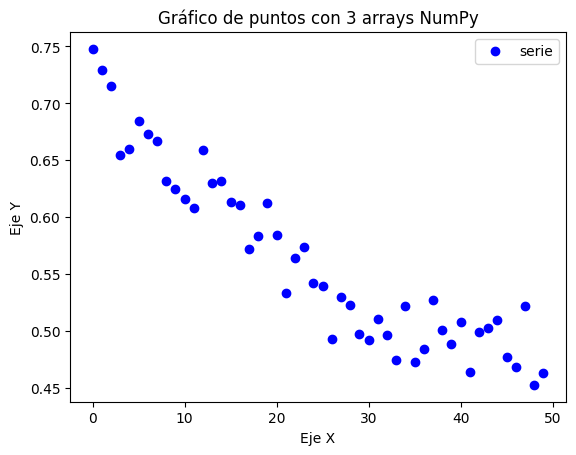

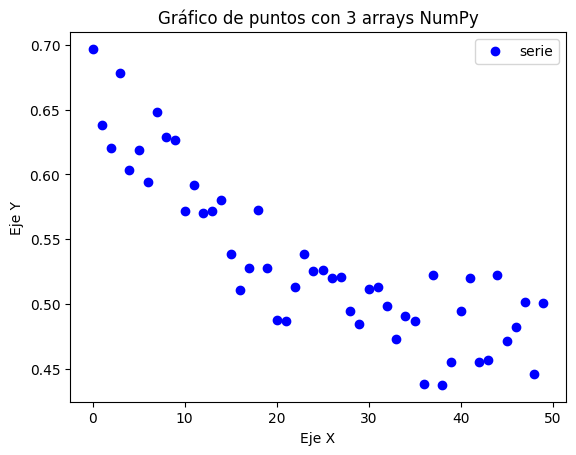

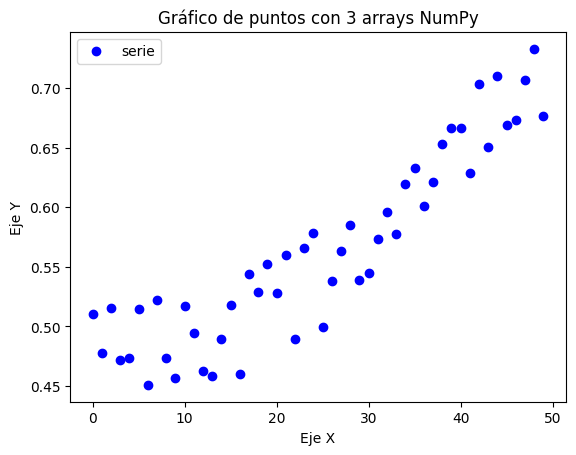

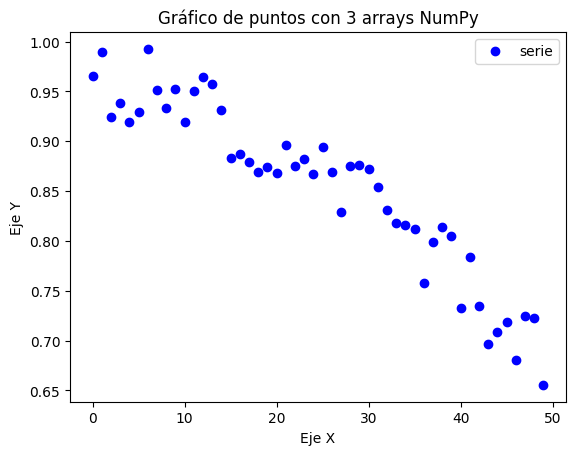

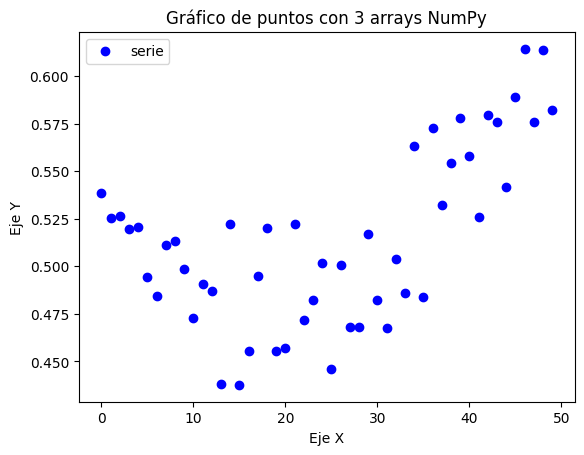

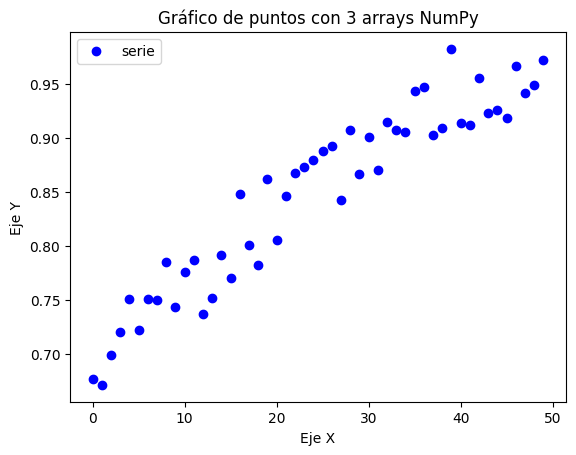

In [48]:
plot_arrays(X_test)

In [49]:
#plot_series(data_final['Color']['test']['X'], data_final['Color']['test']['y'])

In [50]:
from sklearn.metrics import mean_squared_error

y_pred = X_test[:,-1]
mean_squared_error(y_test, y_pred)

1.4725517

In [51]:
y_pred = X_test[:,-1]


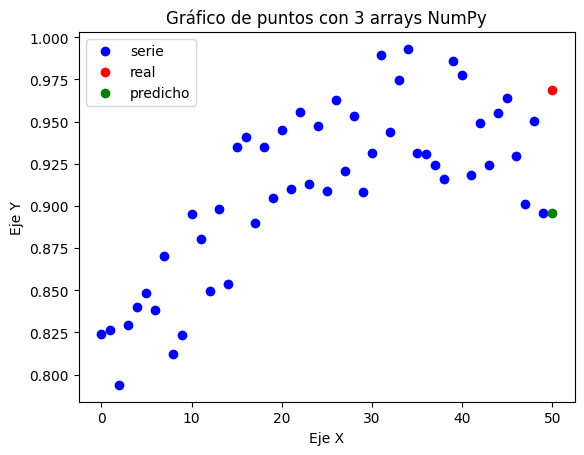

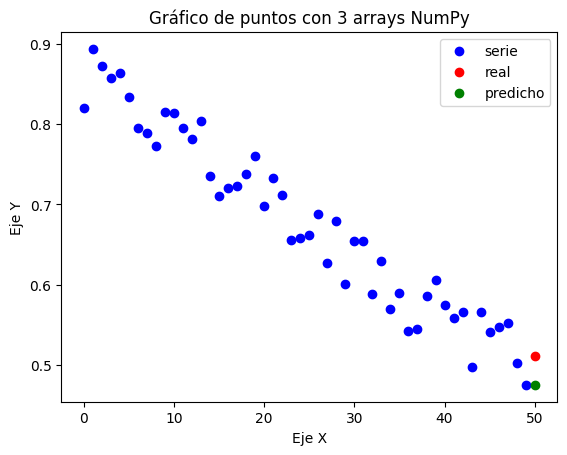

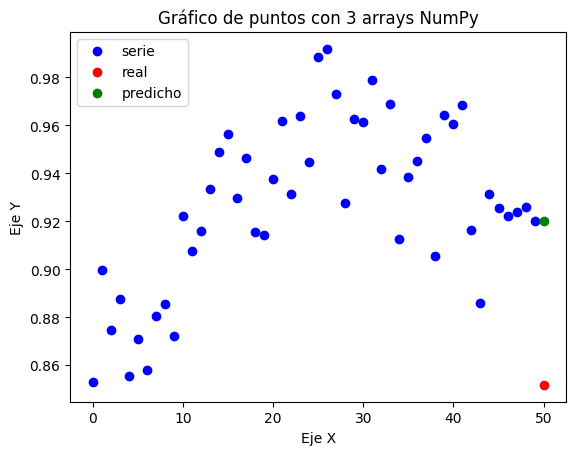

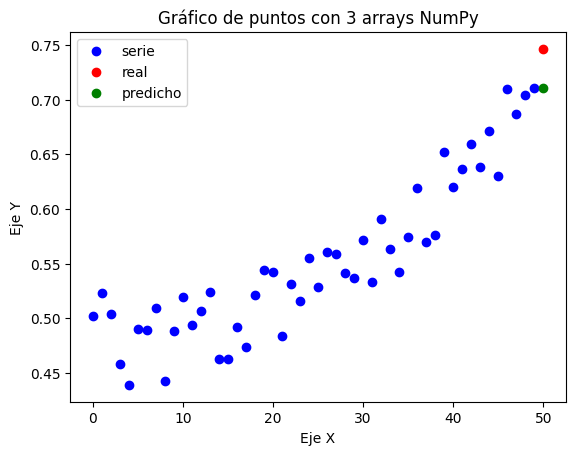

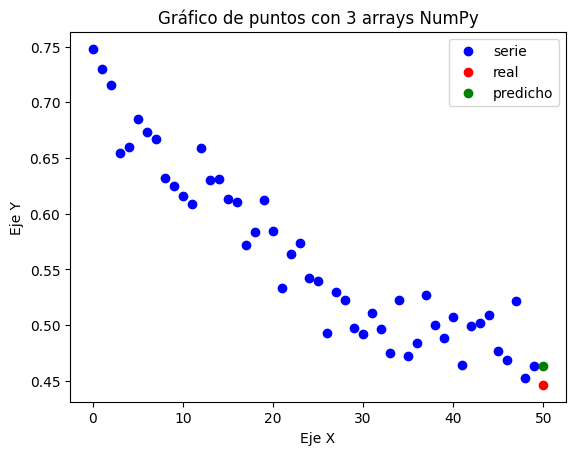

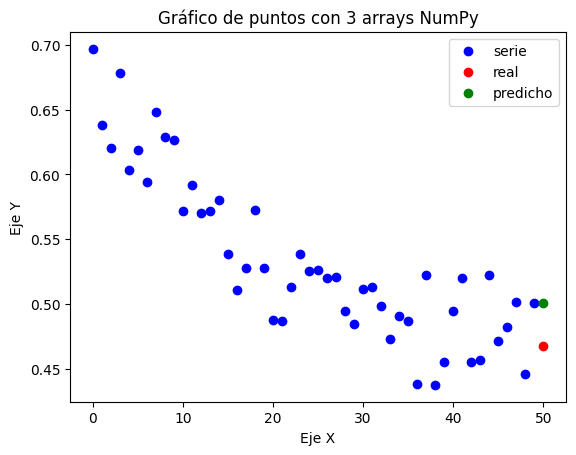

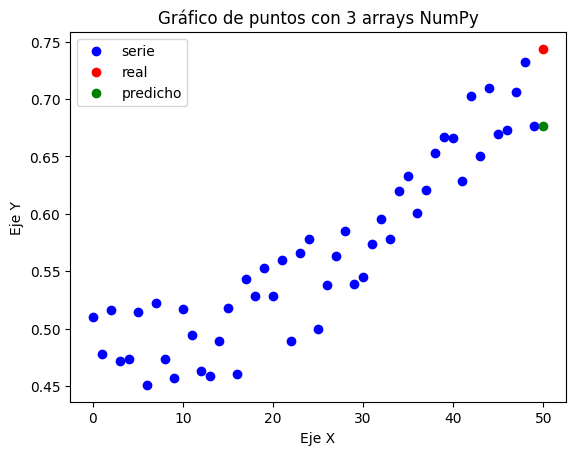

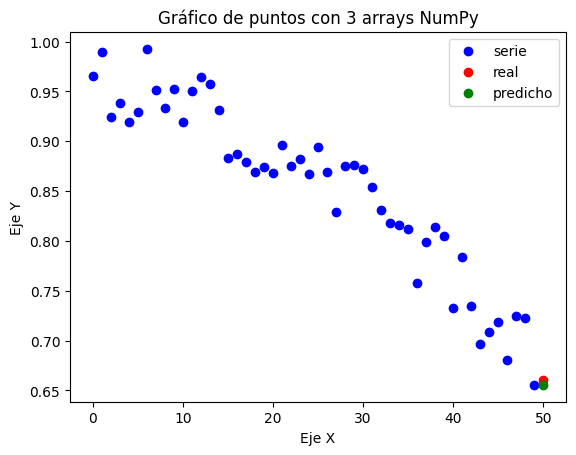

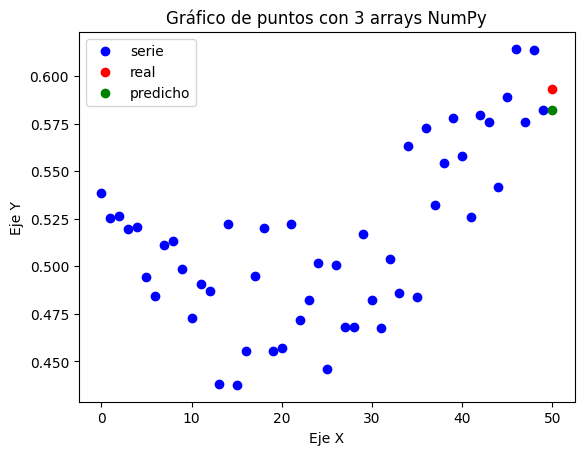

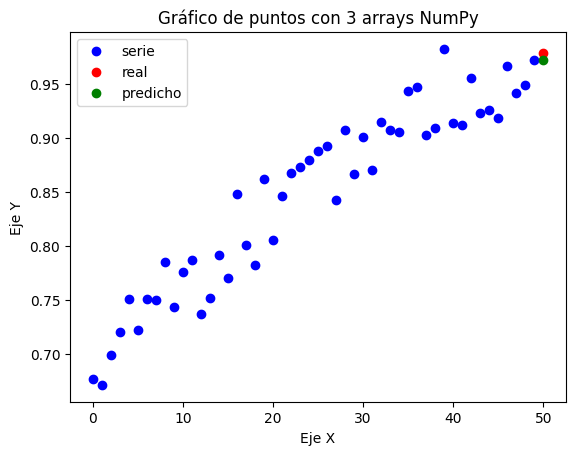

In [52]:
plot_arrays(X_test, y_test, y_pred)

In [53]:
import torch
from torch.utils.data import Dataset, DataLoader

class TimeSeriesDataset(Dataset):
  def __init__(self, X, y=None, train=True):
    self.X = X
    self.y = y
    self.train = train

  def __len__(self):
    return len(self.X)

  def __getitem__(self, ix):
    if self.train:
      return torch.from_numpy(self.X[ix]), torch.from_numpy(self.y[ix])
    return torch.from_numpy(self.X[ix])

dataset = {
    'train': TimeSeriesDataset(X_train, y_train),
    'eval': TimeSeriesDataset(X_valid, y_valid),
    'test': TimeSeriesDataset(X_test, y_test, train=False)
}

dataloader = {
    'train': DataLoader(dataset['train'], shuffle=True, batch_size=64),
    'eval': DataLoader(dataset['eval'], shuffle=False, batch_size=64),
    'test': DataLoader(dataset['test'], shuffle=False, batch_size=64)
}

In [54]:
class MLP(torch.nn.Module):
  def __init__(self, n_in=50, n_out=1):
    super().__init__()
    self.fc = torch.nn.Linear(n_in, n_out)

  def forward(self, x):
    x = x.view(x.shape[0], -1)
    x = self.fc(x)
    return x

mlp = MLP()
mlp

MLP(
  (fc): Linear(in_features=50, out_features=1, bias=True)
)

In [55]:
from tqdm import tqdm
device = "cuda" if torch.cuda.is_available() else "cpu"

def fit(model, dataloader, epochs=10):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = torch.nn.MSELoss()
    bar = tqdm(range(1, epochs+1))
    for epoch in bar:
        model.train()
        train_loss = []
        for batch in dataloader['train']:
            X, y = batch
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(X)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
        model.eval()
        eval_loss = []
        with torch.no_grad():
            for batch in dataloader['eval']:
                X, y = batch
                X, y = X.to(device), y.to(device)
                y_hat = model(X)
                loss = criterion(y_hat, y)
                eval_loss.append(loss.item())
        bar.set_description(f"loss {np.mean(train_loss):.5f} val_loss {np.mean(eval_loss):.5f}")

def predict(model, dataloader):
    model.eval()
    with torch.no_grad():
        preds = torch.tensor([]).to(device)
        for batch in dataloader:
            X = batch
            X = X.to(device)
            pred = model(X)
            preds = torch.cat([preds, pred])
        return preds

In [56]:
fit(mlp, dataloader)

loss 1.17293 val_loss 1.36606: 100%|██████████| 10/10 [00:02<00:00,  4.38it/s]


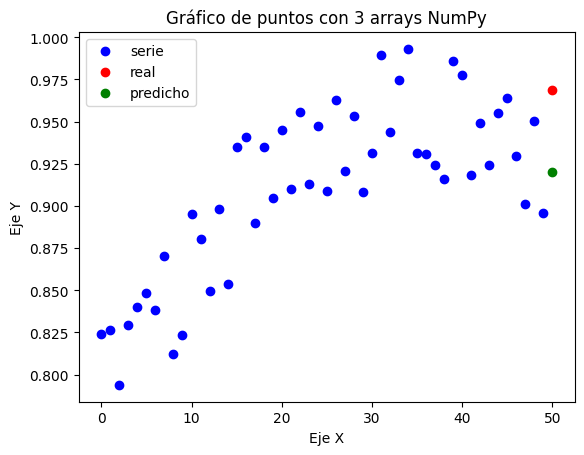

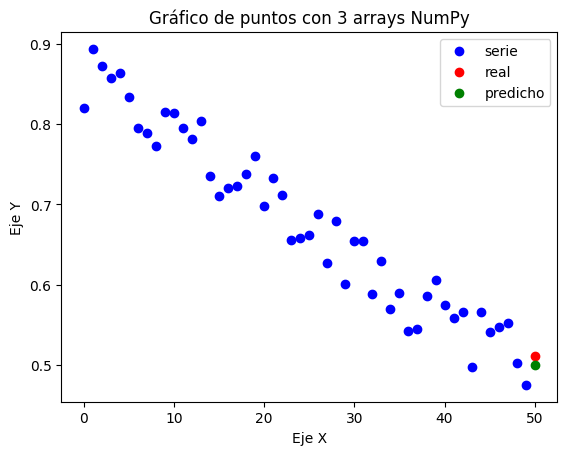

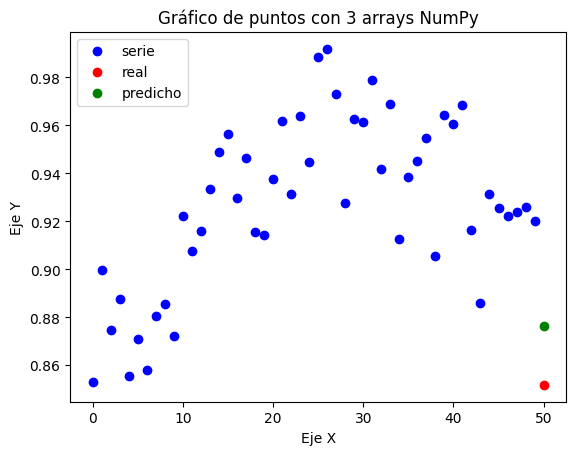

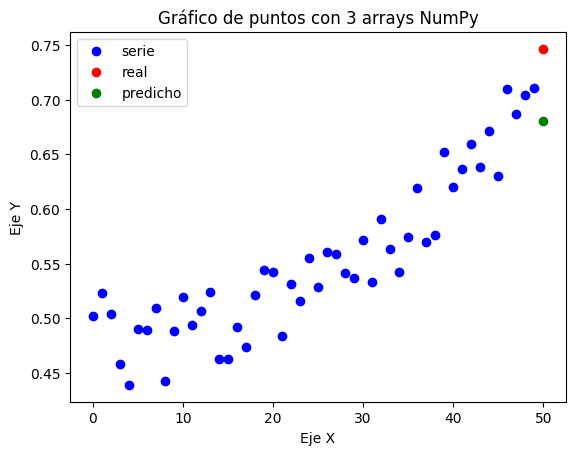

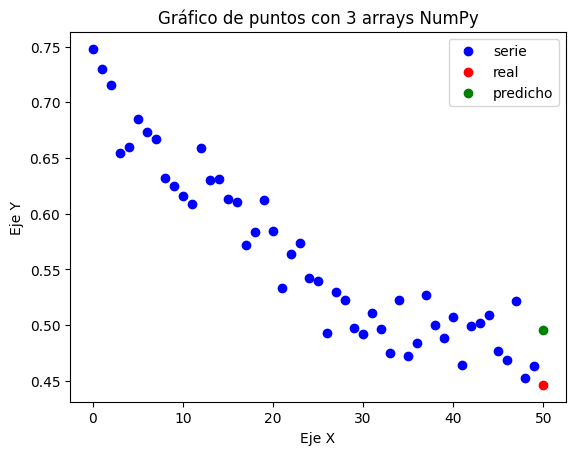

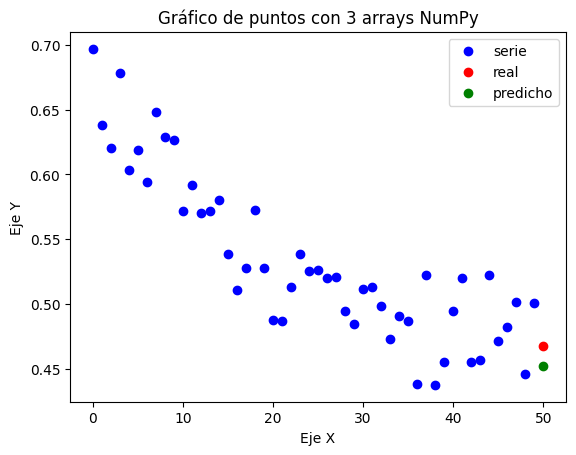

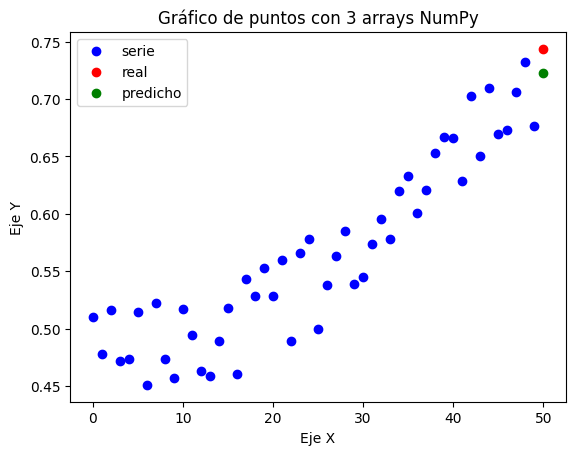

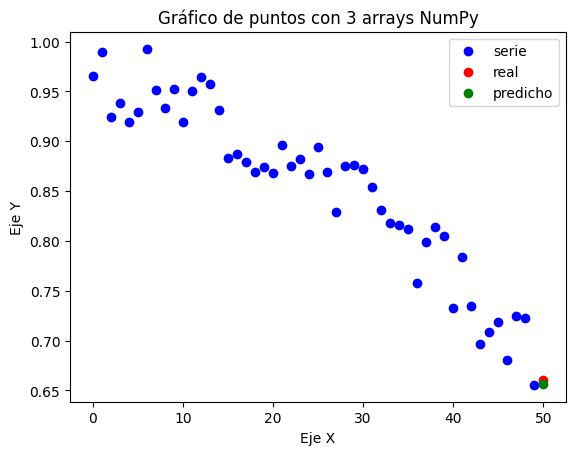

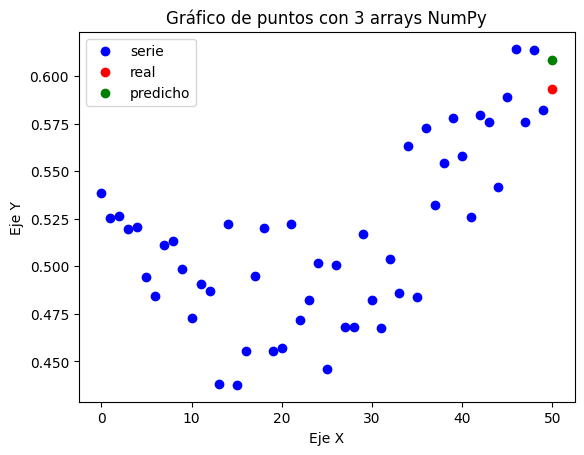

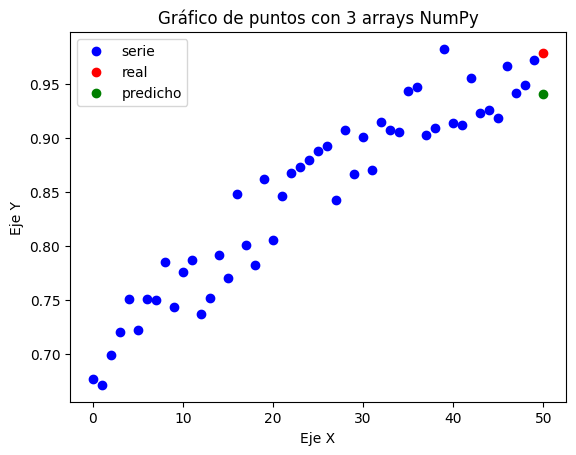

1.32331

In [57]:
y_pred = predict(mlp, dataloader['test'])
plot_arrays(X_test, y_test, y_pred.cpu().numpy())
mean_squared_error(y_test, y_pred.cpu())

In [58]:
class SimpleRNN(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.rnn = torch.nn.RNN(input_size=1, hidden_size=1, num_layers=1, batch_first=True)

  def forward(self, x):
    x, h = self.rnn(x)
    # solo queremos la última salida
    return x[:,-1]

rnn = SimpleRNN()

In [59]:
fit(rnn, dataloader)

loss 599.03119 val_loss 610.23222: 100%|██████████| 10/10 [00:11<00:00,  1.11s/it]


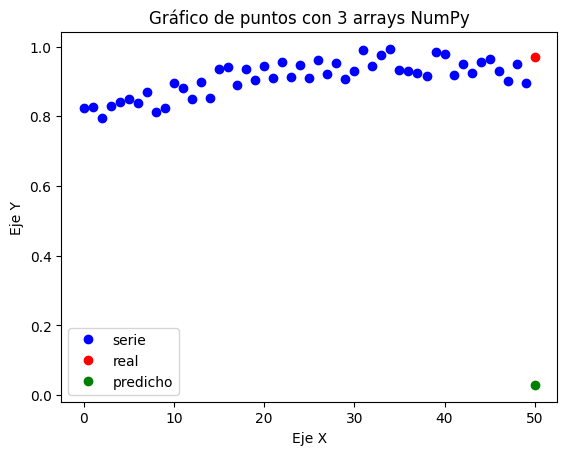

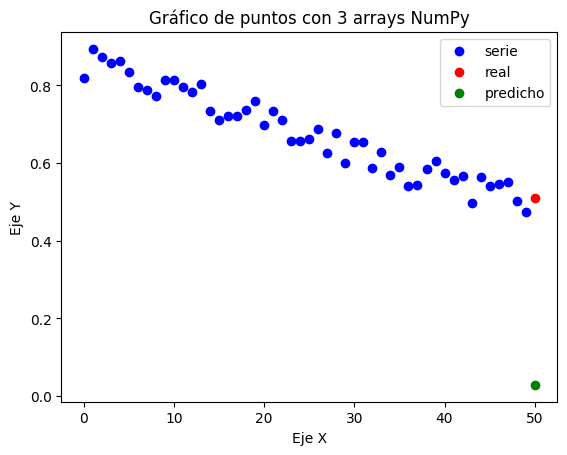

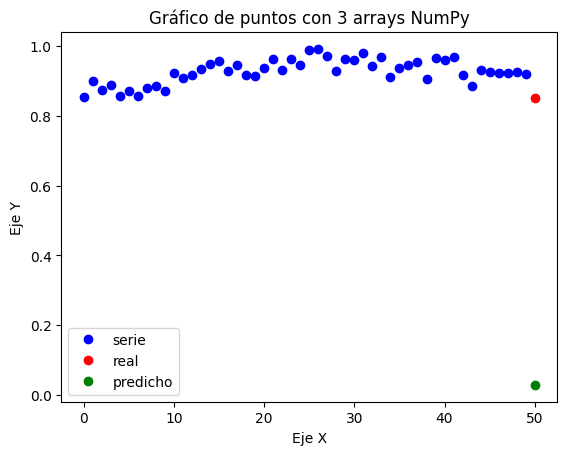

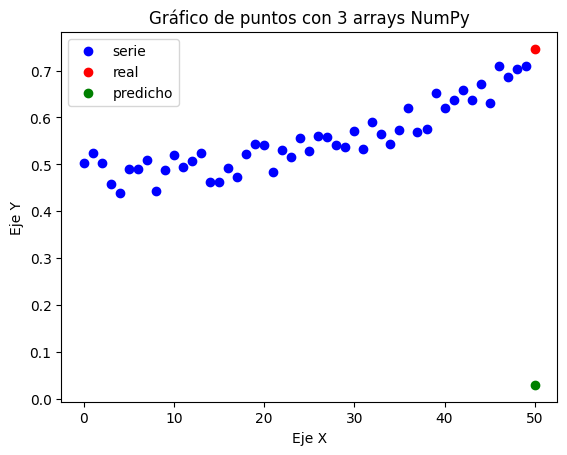

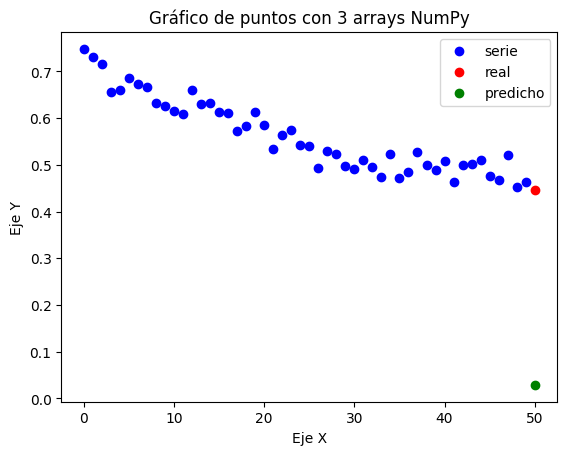

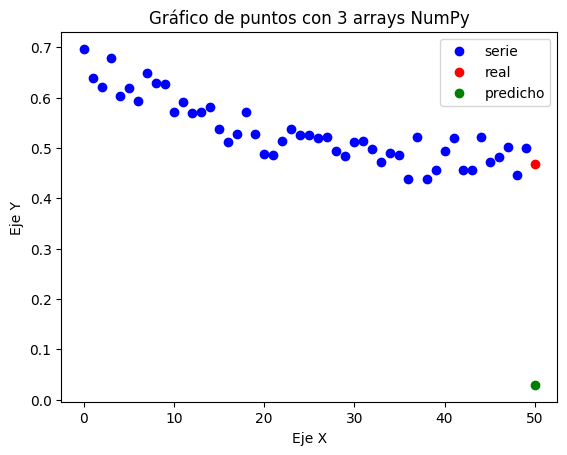

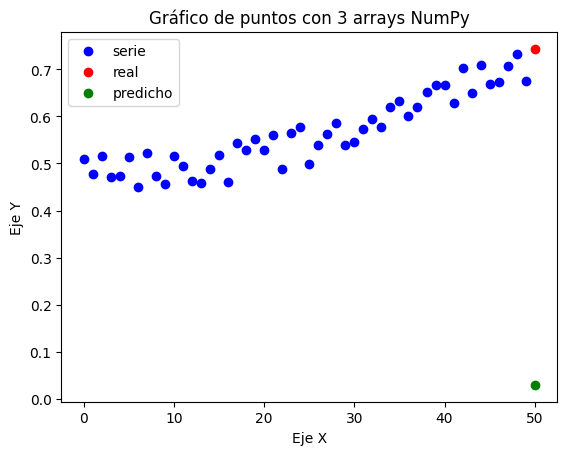

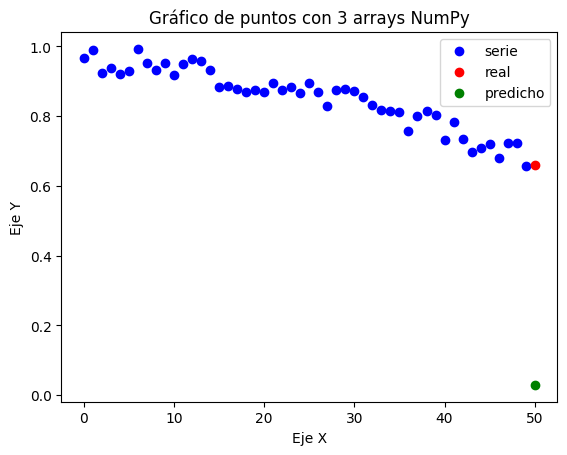

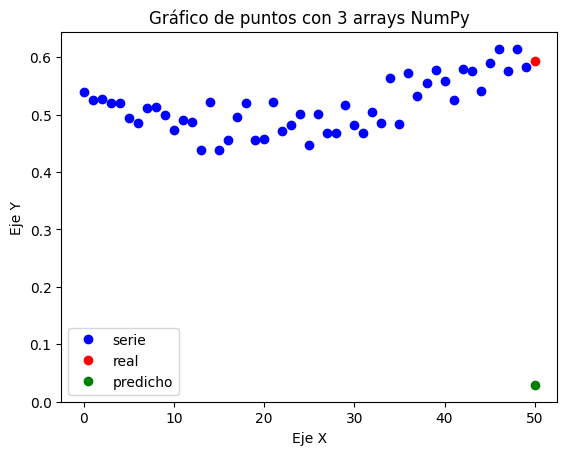

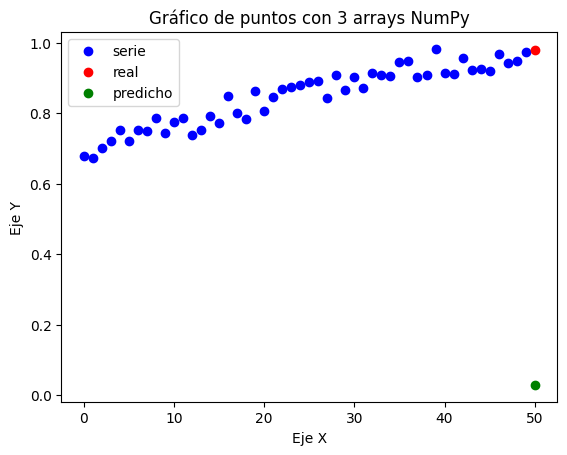

581.8811

In [60]:
y_pred = predict(rnn, dataloader['test'])
plot_arrays(X_test, y_test, y_pred.cpu().numpy())
mean_squared_error(y_test, y_pred.cpu())

In [61]:
# parámetros en el MLP

mlp.fc.weight.shape, mlp.fc.bias.shape

(torch.Size([1, 50]), torch.Size([1]))

In [62]:
# parámetros en la RNN simple

rnn.rnn.weight_hh_l0.shape, rnn.rnn.weight_ih_l0.shape, rnn.rnn.bias_hh_l0.shape, rnn.rnn.bias_ih_l0.shape

(torch.Size([1, 1]), torch.Size([1, 1]), torch.Size([1]), torch.Size([1]))

In [63]:
class RNN(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.rnn = torch.nn.RNN(input_size=1, hidden_size=40, num_layers=1, batch_first=True)
    self.fc = torch.nn.Linear(40, 1)

  def forward(self, x):
    x, h = self.rnn(x)
    # get the last output and apply linear layer
    y = self.fc(x[:,-1])
    return y

rnn = RNN()

In [64]:
# parámetros en la nueva RNN

rnn.rnn.weight_hh_l0.shape, rnn.rnn.weight_ih_l0.shape, rnn.rnn.bias_hh_l0.shape, rnn.rnn.bias_ih_l0.shape, rnn.fc.weight.shape, rnn.fc.bias.shape

(torch.Size([40, 40]),
 torch.Size([40, 1]),
 torch.Size([40]),
 torch.Size([40]),
 torch.Size([1, 40]),
 torch.Size([1]))

In [65]:
fit(rnn, dataloader)

loss 5.78059 val_loss 5.07917: 100%|██████████| 10/10 [00:26<00:00,  2.68s/it]


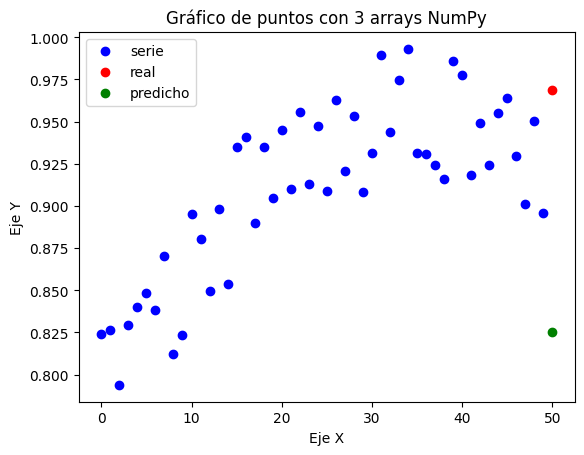

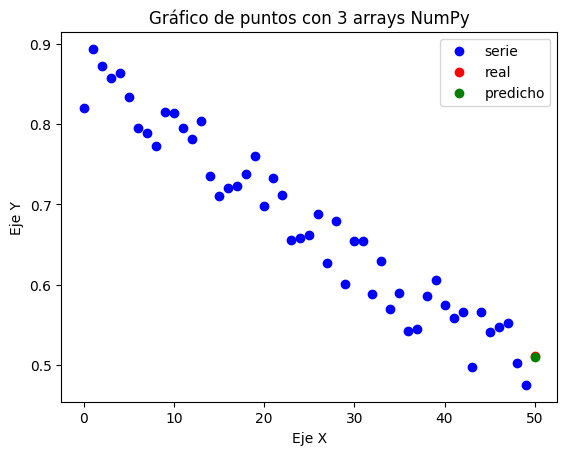

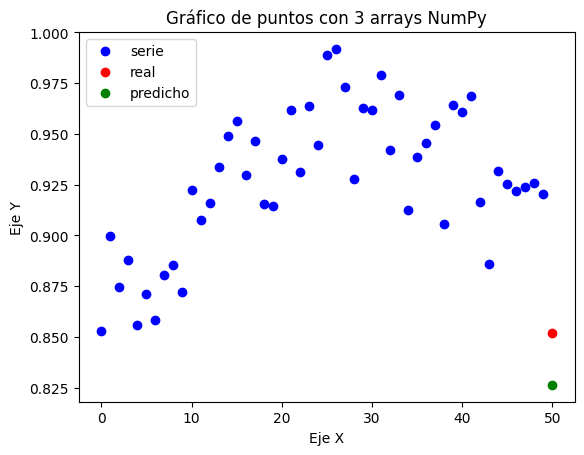

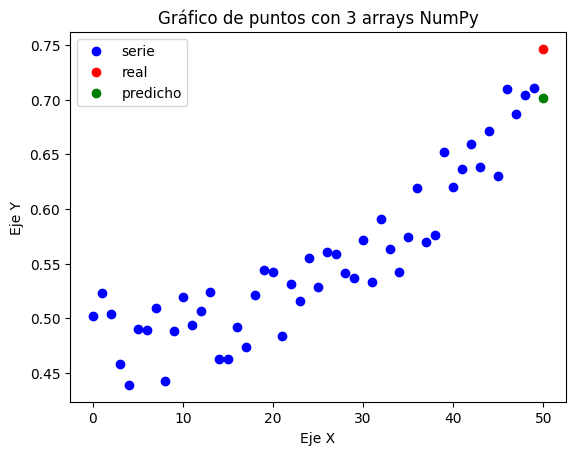

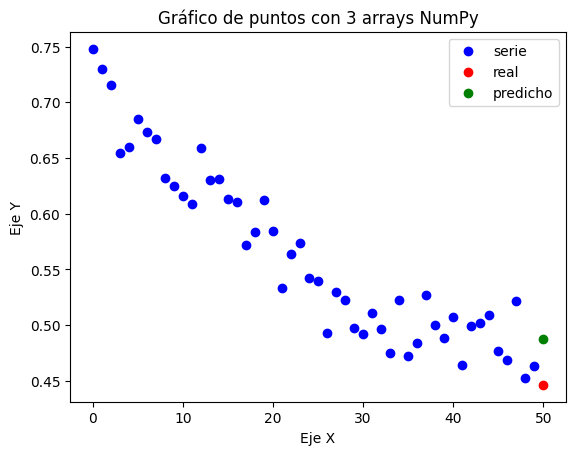

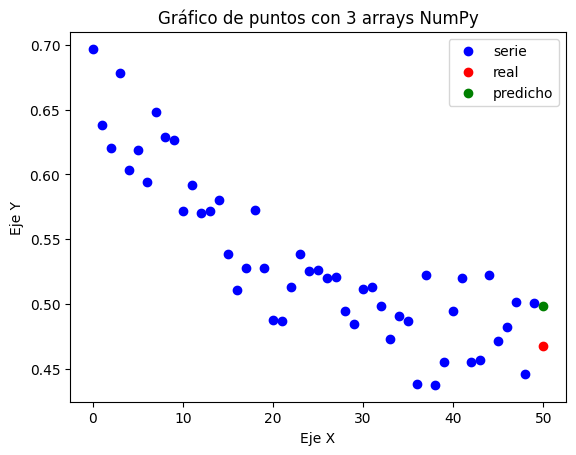

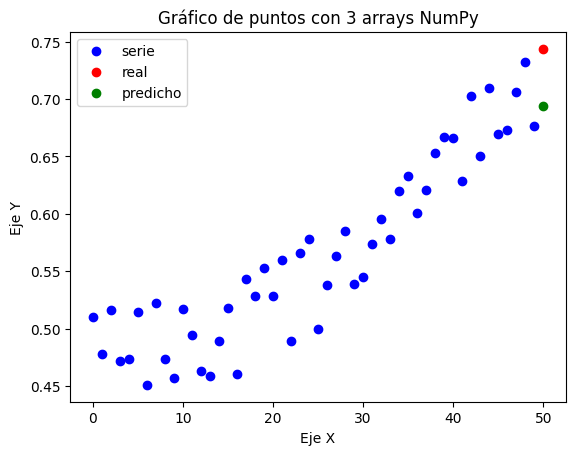

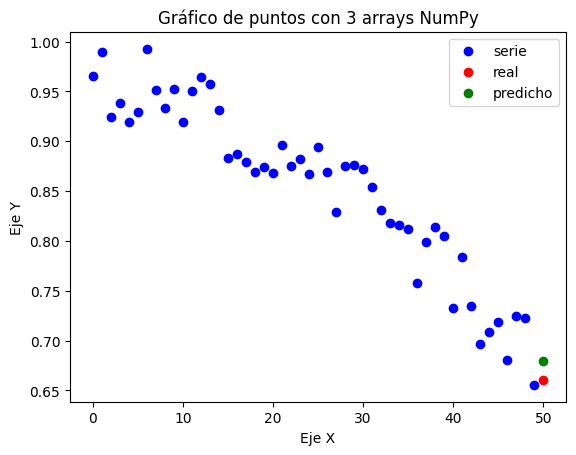

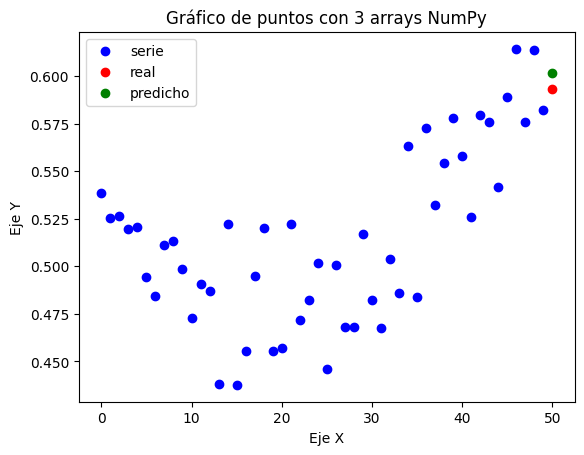

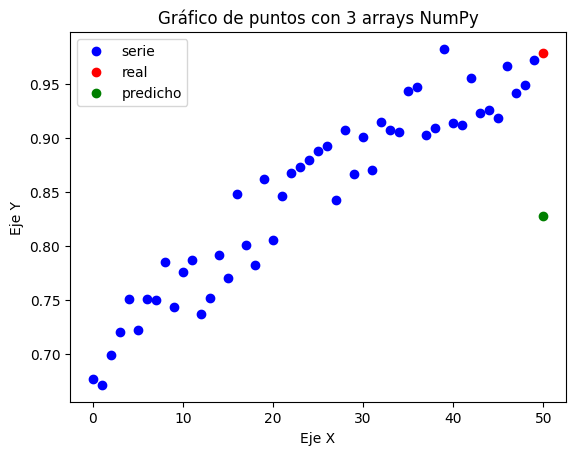

4.5430183

In [66]:
y_pred = predict(rnn, dataloader['test'])
plot_arrays(X_test, y_test, y_pred.cpu().numpy())
mean_squared_error(y_test, y_pred.cpu())